### Import statements

In [2]:
import random 
import math
import matplotlib.pyplot as plt
import time 
import ray
import numpy as np
import imageio

#If it gives an error, ctrl+shift+p - python: select interpreter

In [3]:
#ray.init()

In [4]:
#ray.shutdown()

### Model parameters
Width and height correspond to the boundry of the specimen. Diameter d to the grain size. Set the required void ratio with variable req_void and the tolerance between aggregates with tol. The timeout variable limits the time it spends in the while loop looking for a solution that satisfies req_void > cur_void

In [5]:
width_box = 1.5
height_box = 0.5
d_max = 0.055
d_min = 0.030
tol = 0
requried_void = 0.44
timeout = 120   #[seconds]

r_max = d_max/2
r_min = d_min/2

#### Sieve curve according to Gleisschotter 32/50, class 1 & 2

-> Grain size curves on polybox/papers/SBB
-> Experiment document on polybox -> see dimensions of gpr Model

In [6]:
#Input values: [[mm],lower bound, upper bound]
sieve_63 = np.array([0.063,1,1])
sieve_50 = np.array([0.050,0.7,0.99])    
sieve_40 = np.array([0.040,0.3,0.65])     
sieve_31 = np.array([0.0315,0.01,0.25])
sieve_22 = np.array([0.0224,0.01,0.03])
sieve_low_limit = np.array([0.018,0,0])

grad_curve_bounds = np.vstack([sieve_63,sieve_50,sieve_40,sieve_31,sieve_22,sieve_low_limit])

In [7]:
def pick_rand_curve(grad_curve_bounds):
    #Keep the diameter and initalize matrix
    grad_curve = grad_curve_bounds[:,[0,1]]

    #Use of beta distribution to pick a value between sieve bounds 
    grad_curve[:,1] = np.random.beta(2,2)*(grad_curve_bounds[:,2] - grad_curve_bounds[:,1]) + grad_curve_bounds[:,1]

    return grad_curve

In [8]:
def convert_sieve_curve(grad_curve):
    grad_curve_conv = np.zeros([grad_curve.shape[0]-1,3])
    for i in range(grad_curve.shape[0]-1):
        grad_curve_conv[i] = np.array([grad_curve[i,0]/2,grad_curve[i+1,0]/2,grad_curve[i,1]-grad_curve[i+1,1]])
    return grad_curve_conv


## 2D Circle Random Sequential Adsorption

### Functions

In [9]:
def intersection (r1, cen1, r2, cen2, tol):
    distan = math.sqrt((cen1[0]-cen2[0])**2+(cen1[1]-cen2[1])**2)
    min_Dis = r1+r2+tol

    if distan > min_Dis:
        return False
    else:
        return True   

In [10]:
def any_intersec (cir1, cirList, tol):
    r1 = cir1[2]
    intersec = False
    for cir2 in cirList:
        r2 = cir2[2]
        check = intersection(r1,cir1[0:2],r2,cir2[0:2],tol)
        if check:
            intersec = True
            return intersec
    return intersec

In [11]:
def random_gen (x1,x2):
    value = (x2-x1)*random.random()+x1
    return value

In [12]:
def plot(cirList):
    fig1 = plt.figure()
    for cir in cirList:
        circle1 = plt.Circle((cir[0],cir[1]),cir[2], facecolor='tab:brown',edgecolor='k')
        plt.gcf().gca().add_artist(circle1)
    plt.xlim(0, width_box)
    plt.ylim(0, height_box)
    plt.gca().set_aspect('equal','box')
    plt.show()

In [163]:
def plot_save(cirList,index,filenames,direc):
    fig1 = plt.figure()
    for cir in cirList:
        circle1 = plt.Circle((cir[0],cir[1]),cir[2], facecolor='tab:brown',edgecolor='k')
        plt.gcf().gca().add_artist(circle1)
    plt.xlim(0, width_box)
    plt.ylim(0, height_box)
    plt.gca().set_aspect('equal','box')
    filename = f'images/circle_{index}_{direc}.png'
    filenames.append(filename)
    plt.savefig(filename,dpi=96)
    plt.close()
    return filenames

In [14]:
# @ray.remote
# def rsa_circle_enhanced():
#     cirList = []
#     cur_void = 1
#     timeout_start = time.time()
#     while req_void < cur_void and time.time() < timeout_start + timeout:
#         r_cur = random_gen(r_min,r_max)
#         x_cur = random_gen(r_cur,width_box-r_cur)
#         z_cur = random_gen(r_cur,height_box-r_cur)
#         new_Circle = [x_cur,z_cur,r_cur]

#         if cirList == []:
#             cirList.append(new_Circle)
#         else:
#             check = any_intersec(new_Circle,cirList,tol)
#             if not check:
#                 cirList.append(new_Circle)
#                 cur_void = cur_void - math.pi*new_Circle[2]**2/(height_box*width_box)
#     elapsed_time = round(time.time()-timeout_start,2)
#     print("Found a solution in ",elapsed_time," seconds")
#     return cirList, cur_void
        

In [15]:
def rsa_circle_minmax():
    cirList = []
    cur_void = 1
    timeout_start = time.time()
    while req_void < cur_void and time.time() < timeout_start + timeout:
        r_cur = random_gen(r_min,r_max)
        x_cur = random_gen(r_cur,width_box-r_cur)
        z_cur = random_gen(r_cur,height_box-r_cur)
        new_Circle = [x_cur,z_cur,r_cur]

        if cirList == []:
            cirList.append(new_Circle)
        else:
            check = any_intersec(new_Circle,cirList,tol)
            if not check:
                cirList.append(new_Circle)
                cur_void = cur_void - math.pi*new_Circle[2]**2/(height_box*width_box)
    elapsed_time = round(time.time()-timeout_start,2)
    print("Found a solution in ",elapsed_time," seconds")
    return cirList, cur_void

In [143]:
def rsa_circle_graded(grad_curve, req_void):
    cirList = []
    cur_void = 1
    req_void_cur = 1
    timeout_start = time.time()
    for i,ele in enumerate(grad_curve):
        req_void_cur -= grad_curve[i,2]*(1-req_void)
        while req_void_cur < cur_void and time.time() < timeout_start + timeout:
            
            r_cur = random_gen(grad_curve[i,1],grad_curve[i,0])
            x_cur = random_gen(r_cur,width_box-r_cur)
            z_cur = random_gen(r_cur,height_box-r_cur)
            new_Circle = [x_cur,z_cur,r_cur]

            if cirList == []:
                cirList.append(new_Circle)
            else:
                check = any_intersec(new_Circle,cirList,tol)
                if not check:
                    cirList.append(new_Circle)
                    cur_void = cur_void - math.pi*new_Circle[2]**2/(height_box*width_box)
    elapsed_time = round(time.time()-timeout_start,2)
    print("Found a solution in ",elapsed_time," seconds")
    return cirList, cur_void

### Main program

In [144]:
grad_curve = pick_rand_curve(grad_curve_bounds)
grad_curve_conv = convert_sieve_curve(grad_curve)
cirList, cur_void = rsa_circle_graded(grad_curve_conv, requried_void)

Found a solution in  1.69  seconds


In [ ]:
# future = rsa_circle_enhanced.remote()
# cirList, cur_void = ray.get(future)
# print("Current void",round(cur_void,4))
# plot(cirList)

# cirList, cur_void = rsa_circle_normal()
# print("Current void",round(cur_void,4))

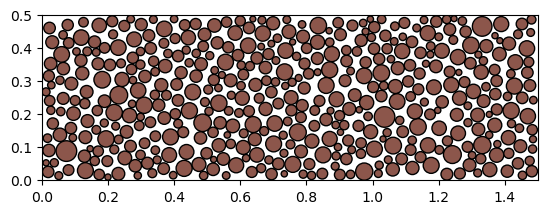

In [145]:
plot(cirList)

## 2D compaction algorithm

### Discretization of simulation domain

In [146]:
def discretization_domain(cirList,h,w,smallest_d,v,horizontal):

    thickness = smallest_d/2 - 0.001
    cirList_np = np.array(cirList)

    if not horizontal:
        num_domains = math.floor(h/thickness)
        max_agg_line = math.floor(w/(smallest_d*(1/(1-v))))
        thickness = round(h/num_domains,3) 

        discret_domains = np.zeros([num_domains,max_agg_line,3]) #3 information per circle (x,y,r)

        for j,t in enumerate(discret_domains):
            condensed_list = cirList_np[np.where((cirList_np[:,1]<=j*thickness+thickness) & (cirList_np[:,1]>=j*thickness))]
            for i,s in enumerate(condensed_list):
                t[i,:]=s 

    else:
        num_domains = math.floor(w/thickness)
        max_agg_line = math.floor(h/(smallest_d*(1/(1-v))))
        thickness = round(w/num_domains,3) 

        discret_domains = np.zeros([num_domains,max_agg_line,3]) #3 information per circle (x,y,r)
        
        cirList_np[:,[1,0]] = cirList_np[:,[0,1]]
        for j,t in enumerate(discret_domains):
            condensed_list = cirList_np[np.where((cirList_np[:,1]<=j*thickness+thickness) & (cirList_np[:,1]>=j*thickness))]
            for i,s in enumerate(condensed_list):
                t[i,:]=s 
   

    return discret_domains, cirList_np, num_domains

### Compaction algorithm


#### Functions

In [147]:
def find_y(cir1, cir2):
    cir1[1] = math.sqrt((cir1[2]+cir2[2])**2 - (cir1[0]-cir2[0])**2) + cir2[1]
    return cir1

In [157]:
def create_gif(filenames,horizontal):
    if horizontal:
        direc = "Horizontal"
    else:
        direc = "Vertical"
    with imageio.get_writer(f'Compaction_Algorithm_{direc}.gif', mode="I") as writer:
        for filename in filenames:
            image = imageio.v2.imread(filename)
            writer.append_data(image)

In [208]:
def compaction(domain_list, cirList,num_domains,horizontal,save_gif):
    #Empty working copy of discrete domains
    comp_circles = np.zeros(cirList.shape)

    #store snapshots of algorithm
    filenames = []

    discret_domain_copy = np.zeros(domain_list.shape)
    np.copyto(discret_domain_copy,domain_list)
    discret_domain_flattend = np.reshape(discret_domain_copy,[num_domains*domain_list.shape[1],domain_list.shape[2]])
    nonzero_domain_flattend = discret_domain_flattend[discret_domain_flattend.any(axis=1)]

    for i in range(domain_list.shape[0]):
        domList1 = domain_list[i]
        #All circles in current and below domains, reshaped so it's a vector of all circles     
        circles_below = np.reshape(domain_list[0:i+1,:,:],[(i+1)*domain_list.shape[1],domain_list.shape[2]])
        
        #All circles in current domain, filtered so there are no zeros
        nonzero_cir_cur = domList1[domList1.any(axis=1)]
        num_cir_cur = nonzero_cir_cur.size//3
        #All circles in current domain, filtered so there are no zeros
        nonzero_cir_below = circles_below[circles_below.any(axis=1)]
        num_cir_below = nonzero_cir_below.size//3

        #Working copy of domain
        comp_cir_domain_cur = nonzero_cir_cur

        for idx in range(nonzero_cir_cur.shape[0]):

            cir1 = nonzero_cir_cur[idx]
            #only circles in x distance r_max are relevant and only the ones that are below (y-coordinate)
            relevant_cir_indizes = np.where((nonzero_cir_below[:,0]-cir1[0] <= cir1[2]+nonzero_cir_below[:,2]) & (nonzero_cir_below[:,0]- cir1[0] >= -(cir1[2]+nonzero_cir_below[:,2])) & (nonzero_cir_below[:,1] < cir1[1]))[0]
            proximity_cir_below = nonzero_cir_below[relevant_cir_indizes]
            if proximity_cir_below.size == 0:
                #it's the bottom one, so move it to the bottom
                comp_cir_domain_cur[idx][1] = cir1[2]
            else:
                #Find maximum y coordinate (minimum travel distance) to all circles below that are within proximity
                comp_cir_domain_cur[idx,1] = np.amax(np.sqrt((cir1[2]+proximity_cir_below[:,2])**2 - (cir1[0]-proximity_cir_below[:,0])**2) + proximity_cir_below[:,1])
            
        #pass compressed domain into saved state
        domain_list[i,0:num_cir_cur,:] = comp_cir_domain_cur
        comp_circles[num_cir_below-num_cir_cur:num_cir_below,:] = comp_cir_domain_cur
        nonzero_domain_flattend[num_cir_below-num_cir_cur:num_cir_below,:] = comp_cir_domain_cur
        
        if save_gif:
            if horizontal:
                nonzero_domain_flattend[:,[1,0]] = nonzero_domain_flattend[:,[0,1]]
                filenames = plot_save(nonzero_domain_flattend,i,filenames,"horizontal")
                nonzero_domain_flattend[:,[1,0]] = nonzero_domain_flattend[:,[0,1]]
            else:
                
                filenames = plot_save(nonzero_domain_flattend,i,filenames,"vertical")
    if horizontal:
        comp_circles[:,[1,0]] = comp_circles[:,[0,1]]
        domain_list[:,:,[1,0]] = domain_list[:,:,[0,1]]

    if save_gif:
        create_gif(filenames, horizontal)
    
    return comp_circles, domain_list

In [205]:
def run_comp_pattern(cirList,h_box,w_box,smallest_d,cur_void,run_pattern,save_gif,show_plot):
    for idx,direc in enumerate(run_pattern):
        for re in range(direc):
            if idx % 2 == 0:
                cirList = run_compaction(cirList,h_box,w_box,smallest_d,cur_void,False,save_gif[idx])
            else:
                cirList = run_compaction(cirList,h_box,w_box,smallest_d,cur_void,True,save_gif[idx])
            
            if show_plot:
                plot(cirList)
    
    return cirList

def run_compaction(cirList,h_box,w_box,smallest_d,cur_void,horizontal,save_gif):
    discret_domains, cirList_np, num_domains = discretization_domain(cirList,h_box,w_box,smallest_d,cur_void,horizontal)
    comp_circles, comp_domain = compaction(discret_domains,cirList_np,num_domains,horizontal,save_gif)

    return comp_circles


#### Main Program

In [222]:
import shutil
shutil.rmtree('images', ignore_errors=True)

KeyboardInterrupt: 

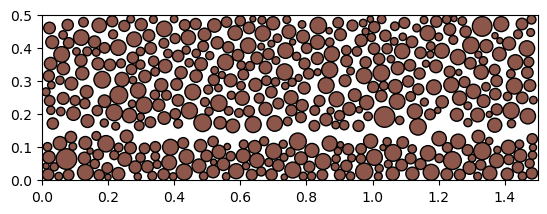

In [221]:
#Insert run pattern, where even index discribes #vertical compactions and odd #horizontal compactions
#For example [2,2,1]: 2 vertical, 2 horizontal and then 1 vertical
run_pattern = [1,1,2,2]

#Insert where gif should be saved, MUST have same shape as run_pattern
#For example [True, True, False]: Saves the latest gif in each direction (vertical / horizontal)
save_gif = [True,True,False,False]

#Show plots after each run?
show_plot = True

#Run Compaction algorithm
comp_cirList = run_comp_pattern(cirList,height_box,width_box,sieve_low_limit[0],cur_void,run_pattern,save_gif,show_plot)

In [202]:
def calc_void(cirList,height,width):
    temp_void = 1
    for cir in cirList:
        temp_void = temp_void - math.pi*cir[2]**2/(height*width)
    return temp_void

#new height of the ballast, round up so we include every circle
y_max = math.ceil(np.amax(comp_circles[:,1])*100)/100

new_void = calc_void(comp_circles,y_max,width_box)
print("New void = ",new_void)


New void =  0.3444528970272871
